In [15]:
import numpy as np
import os 
import pandas as pd
import requests
import io
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
url = 'https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv'

response = requests.get(url, headers=headers)

In [3]:
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
del response

In [4]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [6]:
df.isna().any()

budget                  False
genres                  False
homepage                 True
id                      False
keywords                False
original_language       False
original_title          False
overview                 True
popularity              False
production_companies    False
production_countries    False
release_date             True
revenue                 False
runtime                  True
spoken_languages        False
status                  False
tagline                  True
title                   False
vote_average            False
vote_count              False
dtype: bool

In [65]:
selected_columns = ['genres', 
                    'keywords', 
                    'original_language', 
                    # 'original_title', 
                    'overview', 
                    # 'production_companies', 
                    # 'production_countries', 
                    # 'spoken_languages', 
                    'tagline', 
                   # 'title',
                   ]
selected_df = df.loc[:, selected_columns]  
#if you do df[selected_columns] it will return a view to the data which will cause 
#problems to chained assignments in the future
selected_df.isna().any()

genres               False
keywords             False
original_language    False
overview              True
tagline               True
dtype: bool

In [66]:
selected_df = selected_df.fillna('')
selected_df.isna().any()

genres               False
keywords             False
original_language    False
overview             False
tagline              False
dtype: bool

In [67]:
# selected_df.loc[:, 'runtime'] = selected_df.loc[:, 'runtime'].apply(lambda row: 60.0 if np.isnan(row) else row)
# selected_df.isna().any()

In [68]:
selected_df.loc[:, ['genres', 'keywords',]] = selected_df.loc[:, ['genres', 'keywords']].applymap(lambda x : ' '.join([dctitem['name'] for dctitem in json.loads(x)]))
selected_df

,genres,keywords,original_language,overview,tagline
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,en,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,en,"Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins."
2,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,en,A cryptic message from Bond’s past sends him o...,A Plan No One Escapes
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,en,Following the death of District Attorney Harve...,The Legend Ends
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,en,"John Carter is a war-weary, former military ca...","Lost in our world, found in another."
...,...,...,...,...,...
4798,Action Crime Thriller,united states–mexico barrier legs arms paper k...,es,El Mariachi just wants to play his guitar and ...,"He didn't come looking for trouble, but troubl..."
4799,Comedy Romance,,en,A newlywed couple's honeymoon is upended by th...,A newlywed couple's honeymoon is upended by th...
4800,Comedy Drama Romance TV Movie,date love at first sight narration investigati...,en,"""Signed, Sealed, Delivered"" introduces a dedic...",
4801,,,en,When ambitious New York attorney Sam is sent t...,A New Yorker in Shanghai


In [ ]:
# # Create a boolean mask to identify rows with empty lists
# empty_list_mask = selected_df.loc[:, ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']].applymap(len) == 0

# # Use the mask to drop rows with empty lists
# selected_df = selected_df.loc[~empty_list_mask.any(axis=1)]
# selected_df

In [90]:
documents = []
for item in selected_df.values:
    documents.append(' '.join(item))
len(documents)

4803

In [91]:
documents[0]

'Action Adventure Fantasy Science Fiction culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relations mind and soul 3d en In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Enter the World of Pandora.'

In [112]:
word_net_lemmatizer = WordNetLemmatizer()
stop_words = text.ENGLISH_STOP_WORDS

def my_tokenizer(s) :
    s = s.lower()
    s = nltk.tokenize.word_tokenize(s)
    s = [token.translate(str.maketrans('', '', string.punctuation)) for token in s]
    s = [word_net_lemmatizer.lemmatize(token) for token in s if token not in stop_words]
    return s

tfidf = TfidfVectorizer(
    norm='l2', 
    # tokenizer = my_tokenizer, 
    lowercase=True, 
    max_features=2000,
    stop_words= 'english'
)

X = tfidf.fit_transform(documents)

In [113]:
movie_name = 'Scream 3'
df[df.original_title == movie_name].index

Int64Index([1164], dtype='int64')

In [114]:
df[df.original_title == movie_name]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
1164,40000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",NaN,4234,"[{""id"": 2546, ""name"": ""mask""}, {""id"": 2573, ""n...",en,Scream 3,"A murdering spree begins to happen again, this...",24.992057,"[{""name"": ""Konrad Pictures"", ""id"": 85}, {""name...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2000-02-03,161834276,116.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Someone has taken their love of trilogies one ...,Scream 3,5.7,736


In [116]:
query = X[df[df.original_title == movie_name].index]
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

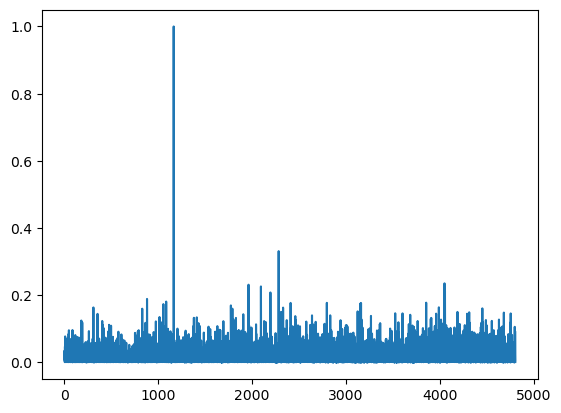

In [117]:
scores = cosine_similarity(query, X).flatten()
plt.plot(scores)

In [118]:
(-scores).argsort()

array([1164, 2282, 4048, ..., 3712, 3686, 3149], dtype=int64)

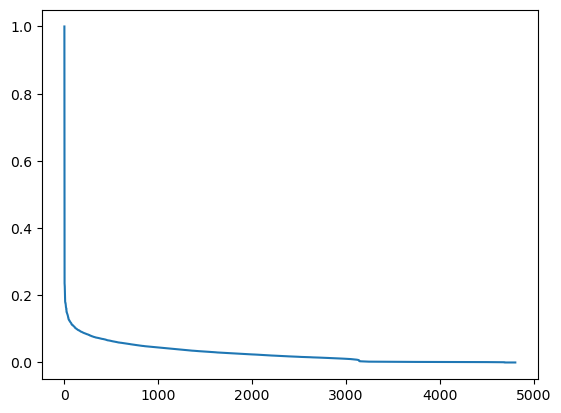

In [119]:
plt.plot(scores[(-scores).argsort()])

In [121]:
#getting the top 5 matches
recommended_idx = (-scores).argsort()[1:6]
df.loc[recommended_idx, :].original_title.values

array(['Scream', 'The Calling', 'Scream 2', 'Jackass 3D',
       'Friday the 13th: A New Beginning'], dtype=object)

In [122]:
def recommend(movie_name) :
    query = X[df[df.original_title == movie_name].index]
    scores = cosine_similarity(query, X).flatten()
    recommended_idx = (-scores).argsort()[1:6]
    return df.loc[recommended_idx, :].original_title.values

In [123]:
recommend('Runaway Bride')

array(['London', 'Mr. Deeds', 'Blonde Ambition', '27 Dresses',
       'Lovely & Amazing'], dtype=object)